In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import catboost as cb

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedShuffleSplit
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

data = pd.read_csv('input_train.csv')
label = pd.read_csv('challenge_output_data_training_file_prediction_of_transaction_claims_status.csv', ';')
all_data = data.merge(label, left_on='ID', right_on='ID', how='inner').copy()
claim_order = sorted(all_data['CLAIM_TYPE'].unique())

# Fixing Structural Errors

In [2]:
# '3/2017' => 201703
temp = all_data['BUYING_DATE'].str.split('/')
all_data['BUYING_DATE'] = temp.str[1] + temp.str[0].str.zfill(2)
all_data['BUYING_DATE'] = all_data['BUYING_DATE'].astype('int32')

# Handle Missing Data

In [3]:
# To improve the Unbalanced Dataset we can delete the missing values for CLAIM_TYPE= '-'
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['BUYER_BIRTHDAY_DATE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_AVERAGE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_MODE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SHIPPING_PRICE'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['PRICECLUB_STATUS'].isna()) ].index)
all_data = all_data.drop(all_data[(all_data['CLAIM_TYPE']=='-') & (all_data['SELLER_SCORE_COUNT'].isna()) ].index)

# Numerical feature 
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].fillna(-1).values
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].fillna(-1).values
all_data['BUYING_DATE']=all_data['BUYING_DATE'].fillna(-1).values
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].fillna(-1).values 

# WARRANTIES_PRICE: There is not missing value but NON_WARRANTIES
all_data['WARRANTIES_PRICE']=all_data['WARRANTIES_PRICE'].fillna('NON_WARRANTIES').values 

# Categorical Features
all_data = all_data.fillna('MISSING')

# Filter Unwanted Outliers

In [4]:
# Attention with missings values > -1
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']<1940) & (all_data['BUYER_BIRTHDAY_DATE']>=0)].index)
all_data = all_data.drop(all_data[(all_data['BUYER_BIRTHDAY_DATE']>=2000) ].index)
all_data = all_data.drop(all_data[(all_data['SELLER_SCORE_AVERAGE']<40) & (all_data['SELLER_SCORE_AVERAGE']>=0)].index)

# Data Type Conversion

In [5]:
all_data['BUYER_BIRTHDAY_DATE']=all_data['BUYER_BIRTHDAY_DATE'].astype(np.int16)
all_data['SELLER_SCORE_AVERAGE']=all_data['SELLER_SCORE_AVERAGE'].astype(np.int16)
all_data['REGISTRATION_DATE']=all_data['REGISTRATION_DATE'].astype(np.int16)
all_data['BUYER_DEPARTMENT']=all_data['BUYER_DEPARTMENT'].astype(np.int16)
all_data['SELLER_DEPARTMENT']=all_data['SELLER_DEPARTMENT'].astype(np.int16)
all_data['CARD_PAYMENT']=all_data['CARD_PAYMENT'].astype(np.bool)
all_data['COUPON_PAYMENT']=all_data['COUPON_PAYMENT'].astype(np.bool)
all_data['RSP_PAYMENT']=all_data['RSP_PAYMENT'].astype(np.bool)
all_data['WALLET_PAYMENT']=all_data['WALLET_PAYMENT'].astype(np.bool)

# Sparse Classes

In [6]:
top10=all_data['SELLER_COUNTRY'].value_counts().head(10).index
all_data.loc[all_data['SELLER_COUNTRY'].isin(top10)==False,'SELLER_COUNTRY'] = 'OTHERS'

top10=all_data['SELLER_DEPARTMENT'].value_counts().head(10).index
all_data.loc[all_data['SELLER_DEPARTMENT'].isin(top10)==False,'SELLER_DEPARTMENT'] = 'OTHERS'

# Encoding

In [7]:
factor = pd.factorize(all_data['CLAIM_TYPE'])
target_number=factor[0]
target_label = factor[1]
target_vectoriser=np.vectorize(dict(zip(range(8),target_label)).get)
lb=LabelBinarizer()


# Remove Unused Features

In [8]:
# REMOVAL OF UNUSEFUL FEATURES
all_data = all_data.drop(["ID"], axis=1)
all_data = all_data.drop(["CLAIM_TYPE"], axis=1)



# Machine Learning

In [9]:
numerical, categorical=list(), list()
for x in all_data.columns : 
    if x  in ['REGISTRATION_DATE','BUYER_BIRTHDAY_DATE','BUYING_DATE','SELLER_SCORE_AVERAGE'] :
        numerical.append(all_data.columns.get_loc(x))
    else :
        categorical.append(all_data.columns.get_loc(x))
        
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[:,self.columns]

In [10]:
def run_gridSearchCV():
    
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
   
    cv = StratifiedShuffleSplit(5, test_size=0.2, random_state=0)
    classifier = cb.CatBoostClassifier(iterations=100, learning_rate=1, random_state=0, loss_function='MultiClass', logging_level='Silent')
        
    params = {
        'clf__depth': np.linspace(1,12,12, dtype=int)
    }
    gs = GridSearchCV(classifier, params, cv=cv, n_jobs=1, scoring='f1_weighted', return_train_score =True)
    gs.fit(X_train,y_train, cat_features=categorical, sample_weight = w)

    cv_results = pd.DataFrame(gs.cv_results_)[['param_clf__depth', 'mean_test_score', 'std_test_score']]
    cv_results.sort_values(by='mean_test_score', ascending=False, inplace=True)
    print(gs.best_params_)

    plt.figure(figsize=(10,5))
    plt.subplot(2,1,1)
    plt.plot(cv_results['param_clf__depth'],cv_results['mean_test_score'],'-o')
    plt.subplot(2,1,2)
    plt.plot(cv_results['param_clf__depth'],cv_results['std_test_score'],'-o')
    plt.show()

{'clf__depth': 1}


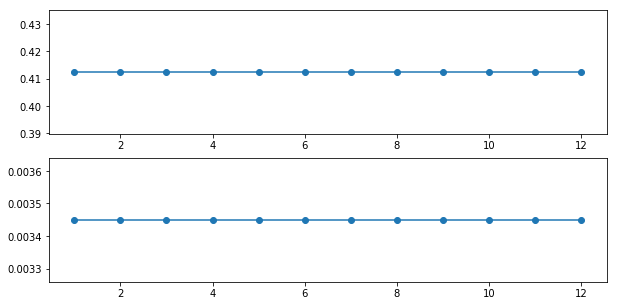

Wall time: 6h 11min 51s


In [11]:
%%time
run_gridSearchCV()

In [12]:
def run_classifier(_depth):
    X_train, X_test, y_train, y_test = train_test_split(all_data.values, target_number, test_size=0.20, random_state=0, stratify=target_number)
    w=compute_sample_weight(class_weight='balanced', y=y_train) 
    
    classifier = cb.CatBoostClassifier(iterations=100, depth=_depth, learning_rate=1, random_state=0, loss_function='MultiClass', logging_level='Silent')
    classifier.fit(X_train, y_train, cat_features=categorical, sample_weight=w)
    y_test_predicted = classifier.predict(X_test)

    y_test_predicted_label = target_vectoriser(y_test_predicted)
    y_test_label = target_vectoriser(y_test)
    print('f1_score:      ',metrics.f1_score(y_test, y_test_predicted, average='weighted'), '\nroc_auc_score: ', metrics.roc_auc_score(lb.fit_transform(y_test), lb.fit_transform(y_test_predicted), average='weighted'), '\n')
    print(classification_report(y_test_label, y_test_predicted_label))

In [13]:
%%time
run_classifier(1)

f1_score:       0.3770943014216416 
roc_auc_score:  0.6404491284937939 

                          precision    recall  f1-score   support

                       -       0.58      0.86      0.69      3059
                 DAMAGED       0.20      0.15      0.17      1159
               DIFFERENT       0.14      0.23      0.17       836
                    FAKE       0.01      0.42      0.02        24
            NOT_RECEIVED       0.55      0.27      0.36      2831
SELLER_CANCEL_POSTERIORI       0.49      0.24      0.32      2698
               UNDEFINED       0.19      0.21      0.20       790
              WITHDRAWAL       0.22      0.21      0.22      1365

             avg / total       0.43      0.38      0.38     12762

Wall time: 15.7 s
